In [2]:
pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 39.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 8.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 13.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import seaborn as sns 
import ast
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.piecewise import PiecewiseAggregateApproximation
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from sktime.utils.plotting import plot_series
from sklearn.metrics import silhouette_score
from sktime.clustering.k_means import TimeSeriesKMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import VarianceThreshold
import itertools
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sktime.classification.kernel_based import RocketClassifier


In [6]:
df_tracks = pd.read_csv(r"/kaggle/input/tabular/tracks.csv")
df_artists = pd.read_csv(r"/kaggle/input/tabular/artists.csv")

# Data Preparation and Understanding

## Duplicate Assessment

In [7]:
# These are duplicates where the entire records is specular to another
df_tracks.duplicated().value_counts()

False    109149
True        398
Name: count, dtype: int64

In [8]:
df_tracks['id'].duplicated().value_counts() # These are other real duplicates, because the primary key is repeated 

id
False    89562
True     19985
Name: count, dtype: int64

In [9]:
df_tracks = df_tracks.drop_duplicates(subset=['id']) 
# Remove the records with duplicated id from df_tracks --> Now we have 89562 records

In [10]:
df_tracks[df_tracks['name'].duplicated()].shape 
# There are 16091 records w/ duplicate names

(16091, 34)

In [11]:
df_tracks = df_tracks.drop_duplicates(subset=['name', 'artists', 'album_type', 'album_name']) 
# Removing songs where these parameters are duplicated (only =name was not enough, but if all these four are the same across two different records, then it's a duplicate)

In [12]:
df_tracks[df_tracks['name'].duplicated()].shape  
#317 more records have been removed 

(15774, 34)

In [13]:
# Final df without duplicates
df_tracks.shape 

(89245, 34)

## Correlation Matrix

Text(0.5, 1.0, 'Features Correlation')

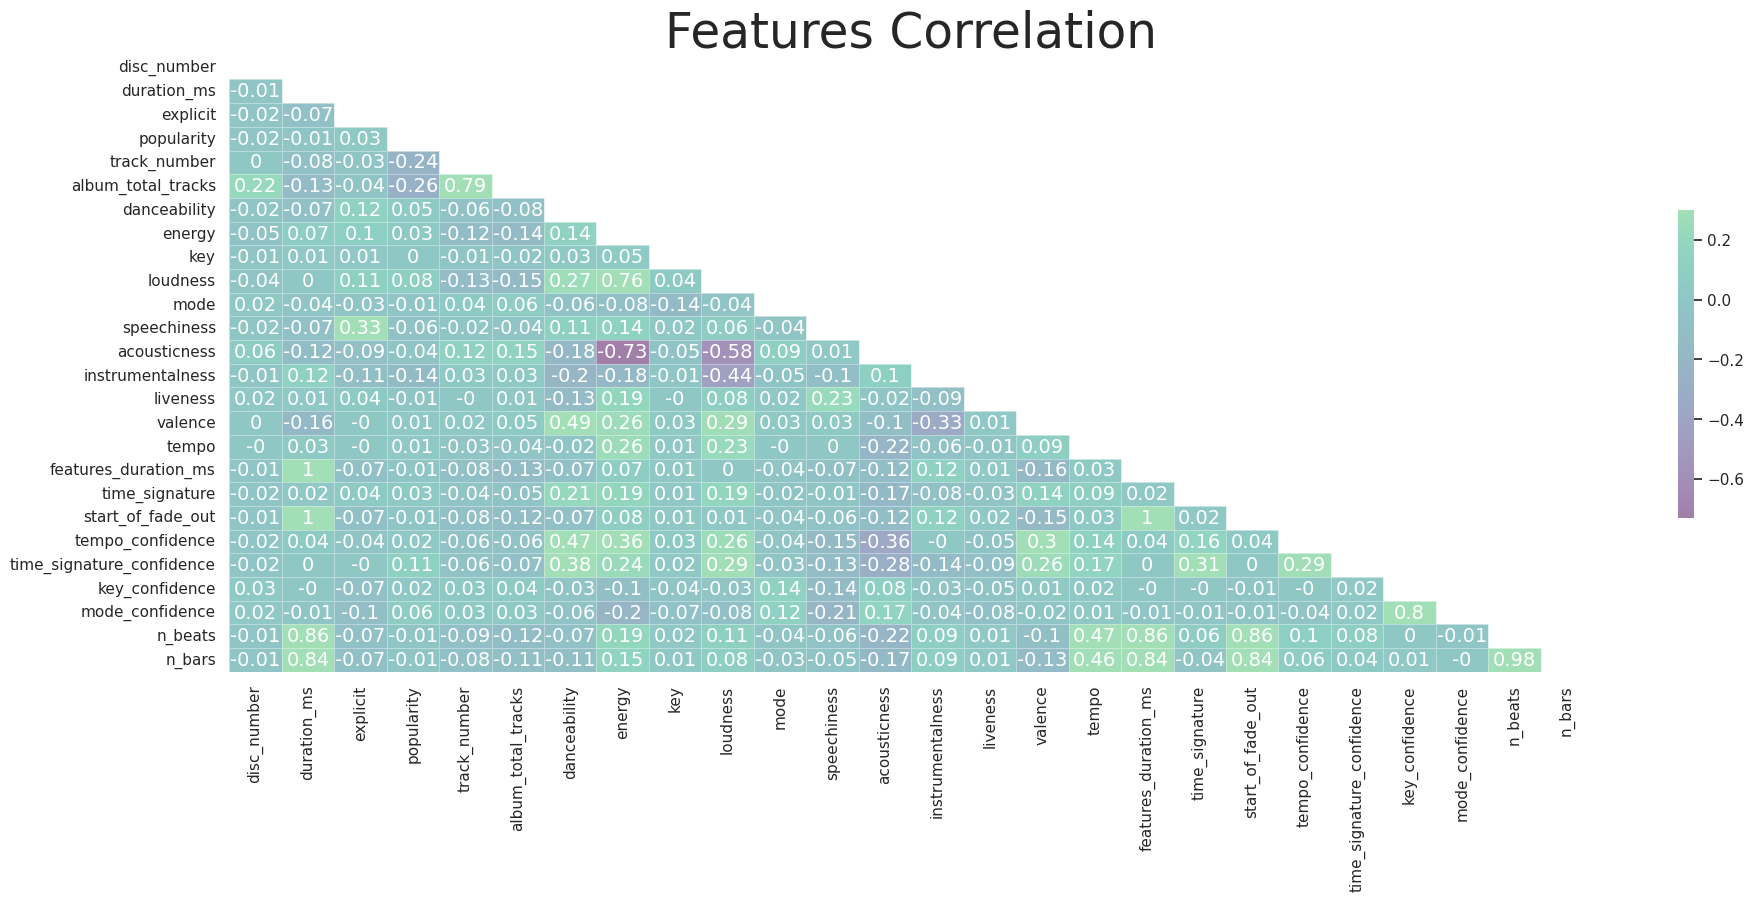

In [14]:
# Correlation between numerical features of the DF (rounded for visualization purposes)
corr = df_tracks.corr(numeric_only=True).round(2)

sns.set_theme(style='white')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(22, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap='viridis', vmax=.3, center=0,
        linewidths=.5, cbar_kws={"shrink": .5},annot=True, annot_kws={"size": 14}, alpha=.5)

plt.title('Features Correlation', fontsize=35)

In [15]:
# disc_number is not informative, will be removed
df_tracks['disc_number'].value_counts() 

disc_number
1     87667
2      1223
3       179
4        53
5        30
6        26
7        25
8        14
9        14
10        9
11        4
14        1
Name: count, dtype: int64

In [16]:
df_tracks = df_tracks[['id', 'name', 'duration_ms', 'explicit', 'popularity', 'artists', 'album_type', 'album_name',
       'album_release_date','album_total_tracks', 'danceability', 'energy','speechiness', 'instrumentalness', 'liveness',
       'valence', 'time_signature','start_of_fade_out','n_beats','genre']]

# We remove acousticness, track number, loudness, n_bars, tempo, mode, key, tempo_conf, key_conf, ts_conf, mode_conf, feature_dur for correlation reasons (more info on the report)

In [17]:
df_tracks.shape 
# 20 features remaining 

(89245, 20)

## Feature Engineering

In [18]:
# Convert 'date' column to datetime type
df_tracks['album_release_date'] = pd.to_datetime(df_tracks['album_release_date'], format='mixed')

In [19]:
# Extract year and month into separate columns
df_tracks['album_release_year'] = df_tracks['album_release_date'].dt.year
df_tracks['album_release_month'] = df_tracks['album_release_date'].dt.month

In [20]:
# Convert columns to nullable integer type to preserve NaNs
df_tracks['album_release_year'] = df_tracks['album_release_year'].astype('Int64')
df_tracks['album_release_month'] = df_tracks['album_release_month'].astype('Int64')


In [21]:
# Convert 'start_of_fade_out' values from seconds to milliseconds and convert to int
df_tracks['start_of_fade_out'] = df_tracks[['start_of_fade_out']]*1000
df_tracks['start_of_fade_out'] = df_tracks['start_of_fade_out'].astype(int)

In [22]:
# Calculate duration of the fade-out effect in milliseconds
df_tracks['fade_out_duration'] = df_tracks['duration_ms'] - df_tracks['start_of_fade_out']

In [23]:
# Number of songs with effective fade_out (100059)
(df_tracks['fade_out_duration'] < 0).sum()

39

In [24]:
# Assign 1 to the values where fade out is lower than 0
df_tracks.loc[df_tracks['fade_out_duration'] < 0, 'fade_out_duration'] = 0

In [25]:
# Mapping Explicit (0 = False; 1 = True)
df_tracks['explicit'] = df_tracks['explicit'].astype(int)

In [26]:
df_tracks['explicit'].value_counts()

explicit
0    81514
1     7731
Name: count, dtype: int64

In [27]:
#### Now working on df_artists with the goal of merging it to df_tracks 

# N° of unique artist in the original DS (featuring included)
print (len(df_tracks['artists'].unique()))

# N° of unique artist in the artists DS
print(len(df_artists['name'].unique()))

31478
29918


In [28]:
# Looking for duplicates in artists DS
df_artists[df_artists['name'].isna()]

,id,name,popularity,followers,genres
11872,NaN,NaN,NaN,NaN,NaN
21223,4oPYazJJ1o4rWBrTw9lm40,NaN,47.0,35655.0,[]


In [29]:
# There were two missing artist's name, removed. 
df_artists.drop(index=11872, inplace=True)
df_artists.drop(index=21223, inplace=True)

In [30]:
# Cast 'followers' and 'popularity' from float to int 
df_artists['followers'] = df_artists['followers'].astype(int)
df_artists['popularity'] = df_artists['popularity'].astype(int)

In [31]:
df_artists.duplicated().value_counts()

False    30137
True         2
Name: count, dtype: int64

In [32]:
# remove also 2 duplicated id records
df_artists = df_artists.drop_duplicates(subset=['id'])

 ### Merging DataFrames using TrackID and ArtistID

In [33]:
# Make a copy of the 'genres' column
genres_copy = df_artists['genres'].copy()

# Iterate over the indices of the DataFrame and update the 'genres' column
for i in range(len(genres_copy)):
    if not pd.isnull(genres_copy.iloc[i]):
        genres_copy.iloc[i] = ast.literal_eval(genres_copy.iloc[i])

# Update the 'genres' column in the original DataFrame
df_artists['genres'] = genres_copy


In [35]:
# Step 1: Initialize primary_artist_id and other_artists_id columns in tracks DataFrame
df_tracks['primary_artist_id'] = None
df_tracks['other_artists_id'] = None

# Step 2: Iterate through each row in tracks DataFrame to populate primary_artist_id and other_artists_id
for index, row in df_tracks.iterrows():
    artists = row['artists'].split(';')  # Split artists by ';'
    
    # Initialize variables to store primary artist ID and other artists IDs
    primary_artist_id = None
    other_artists_ids = []
    
    # Iterate through each artist in the list
    for artist in artists:
        # Check if artist exists in artists DataFrame
        artist_row = df_artists[df_artists['name'] == artist.strip()]  # strip to remove leading/trailing spaces
        
        if not artist_row.empty:
            # If artist exists, get the ID
            artist_id = artist_row['id'].values[0]
            
            # If primary_artist_id is not set yet, set it
            if primary_artist_id is None:
                primary_artist_id = artist_id
            else:
                # If primary_artist_id is already set, append the ID to other_artists_ids
                other_artists_ids.append(artist_id)
    
    # Update the tracks DataFrame with primary_artist_id and other_artists_id
    df_tracks.at[index, 'primary_artist_id'] = primary_artist_id
    df_tracks.at[index, 'other_artists_id'] = other_artists_ids

In [36]:
# Display the rows where primary_artist_id is missing
missing_primary_artist_ids_df = df_tracks[df_tracks['primary_artist_id'].isnull()]
missing_primary_artist_ids_df

,id,name,duration_ms,explicit,popularity,artists,album_type,album_name,album_release_date,album_total_tracks,...,valence,time_signature,start_of_fade_out,n_beats,genre,album_release_year,album_release_month,fade_out_duration,primary_artist_id,other_artists_id
20959,5CIHSAYZZ9ppV7wCDfBEcV,Matemática,190586,0,51,ReStarT,album,Geração Z,2011-10-20,12,...,0.858,4,179612,542.0,brazil,2011,10,10974,None,[]
58486,4UXIejXKvrHnbKoCNxojQA,Drinking On A Tuesday,196707,0,42,Patrick Brasca,single,Drinking On A Tuesday,2021-12-14,1,...,0.914,4,192946,400.0,mandopop,2021,12,3761,None,[]


In [37]:
# Remove the rows where primary_artist_id is missing
df_tracks.drop([20959, 58486], inplace=True)

In [38]:
# Get unique artist IDs from df_artists
valid_artist_ids = set(df_artists['id'])

# Get unique primary_artist_id and other_artists_id from df_tracks
primary_artist_ids = set(df_tracks['primary_artist_id'].dropna())
other_artists_ids = set(df_tracks['other_artists_id'].explode().dropna())

# Check if primary_artist_id and other_artists_id are valid artist IDs
primary_ids_difference = primary_artist_ids - valid_artist_ids
other_ids_difference = other_artists_ids - valid_artist_ids

if primary_ids_difference:
    print(f"The following primary_artist_id(s) in df_tracks do not exist in df_artists: {primary_ids_difference}")

if other_ids_difference:
    print(f"The following other_artists_id(s) in df_tracks do not exist in df_artists: {other_ids_difference}")

if not primary_ids_difference and not other_ids_difference:
    print("All primary_artist_id and other_artists_id in df_tracks exist in df_artists.")

All primary_artist_id and other_artists_id in df_tracks exist in df_artists.


In [39]:
empty_lists_count = df_tracks['other_artists_id'].apply(lambda x: len(x) == 0).sum()
empty_lists_count

66660

In [40]:
# Populate the list with the indexes to remove
indices_to_remove = []
for i in range(len(df_tracks['artists'])):
    if ';' in df_tracks['artists'].iloc[i] and df_tracks['other_artists_id'].iloc[i] == []:
        indices_to_remove.append(i)
        
# Remove records
indexes = df_tracks.iloc[indices_to_remove].index
df_tracks.drop(indexes, inplace= True)

In [41]:
# Create a dictionary to map artist IDs to their popularity
artist_popularity_dict = dict(zip(df_artists['id'], df_artists['popularity']))

# Map the popularity values based on primary_artist_id
df_tracks['primary_artist_popularity'] = df_tracks['primary_artist_id'].map(artist_popularity_dict)


In [42]:
# Define a function to map artist IDs to their popularity and create a list
def get_other_artists_popularity(artist_id_list):
    popularity_list = []
    for artist_id in artist_id_list:
        # If artist_id is not NaN and exists in df_artists, append its popularity to the list
        if not pd.isnull(artist_id):
            popularity = df_artists.loc[df_artists['id'] == artist_id, 'popularity'].iloc[0]
            popularity_list.append(popularity)
    return popularity_list

# Apply the function to each row to create the 'other_artists_popularity' column
df_tracks['other_artists_popularity'] = df_tracks['other_artists_id'].apply(get_other_artists_popularity)

In [43]:
# Check if the length of the lists in 'other_artists_id' is equal to the length of the lists in 'other_artists_popularity'
is_length_equal = (df_tracks['other_artists_id'].apply(len) == df_tracks['other_artists_popularity'].apply(len)).all()

# Output the result
print("Are the lengths equal?", is_length_equal)

Are the lengths equal? True


In [44]:
# Define a function to calculate the mean of all elements in the lists along with the primary_artist_popularity
def calculate_average_popularity(popularity_list, primary_popularity):
    # Combine the popularity list with the primary popularity
    combined_list = popularity_list + [primary_popularity]
    # Calculate the mean of all elements
    return np.mean(combined_list)

# Apply the function to each row to create the 'average_artists_popularity' column
df_tracks['average_artists_popularity'] = df_tracks.apply(lambda row: calculate_average_popularity(row['other_artists_popularity'], row['primary_artist_popularity']), axis=1)

In [45]:
# Round the values of the 'average_artists_popularity' column to the nearest integer and convert to int
df_tracks['average_artists_popularity'] = df_tracks['average_artists_popularity'].round().astype(int)


In [46]:
# Define a function to calculate the sum of followers for primary and other artists
def calculate_sum_of_followers(primary_id, other_ids):
    # Initialize the sum with the primary artist's followers
    sum_followers = df_artists.loc[df_artists['id'] == primary_id, 'followers'].iloc[0]
    
    # Add the followers of other artists
    if other_ids:  # Check if other_ids is not empty
        sum_followers += sum(df_artists.loc[df_artists['id'].isin(other_ids), 'followers'])
    
    return sum_followers

# Apply the function to each row to create the 'sum_of_followers' column
df_tracks['sum_of_followers'] = df_tracks.apply(lambda row: calculate_sum_of_followers(row['primary_artist_id'], row['other_artists_id']), axis=1)

In [47]:
df_tracks.columns

Index(['id', 'name', 'duration_ms', 'explicit', 'popularity', 'artists',
       'album_type', 'album_name', 'album_release_date', 'album_total_tracks',
       'danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness',
       'valence', 'time_signature', 'start_of_fade_out', 'n_beats', 'genre',
       'album_release_year', 'album_release_month', 'fade_out_duration',
       'primary_artist_id', 'other_artists_id', 'primary_artist_popularity',
       'other_artists_popularity', 'average_artists_popularity',
       'sum_of_followers'],
      dtype='object')

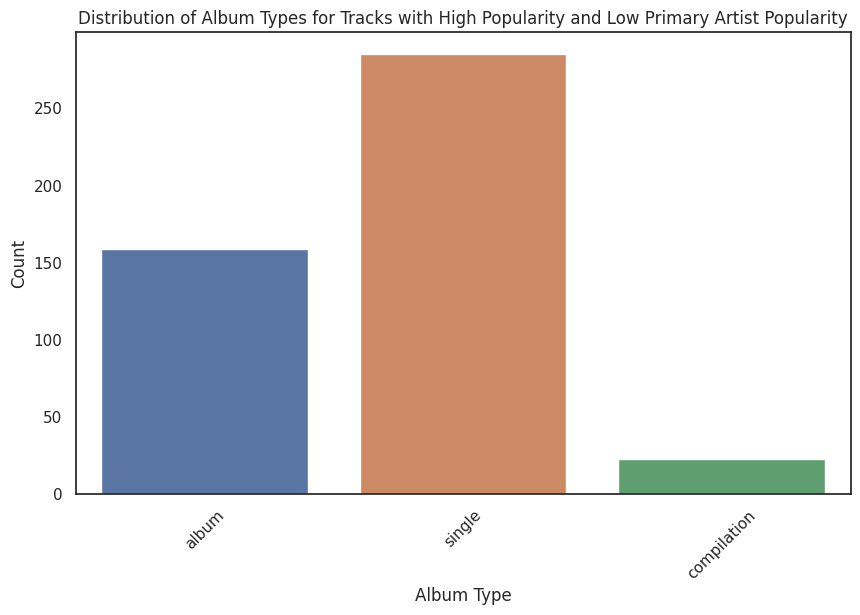

In [48]:
#### Checking association between track popularity and artist popularity

# Define the threshold for high popularity
popularity_threshold = 48  # 3rd quartile of the distribution
primary_artist_popularity_threshold = 38 #1st quartile of the distribution

# Filter the DataFrame to include only tracks meeting the specified criteria
filtered_tracks = df_tracks[(df_tracks['popularity'] > popularity_threshold) & (df_tracks['primary_artist_popularity'] < primary_artist_popularity_threshold)]

# Create a count plot to visualize the distribution of album types for tracks meeting the criteria
plt.figure(figsize=(10, 6))
sns.countplot(x='album_type', data=filtered_tracks)
plt.title('Distribution of Album Types for Tracks with High Popularity and Low Primary Artist Popularity')
plt.xlabel('Album Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Seasonality Assessment

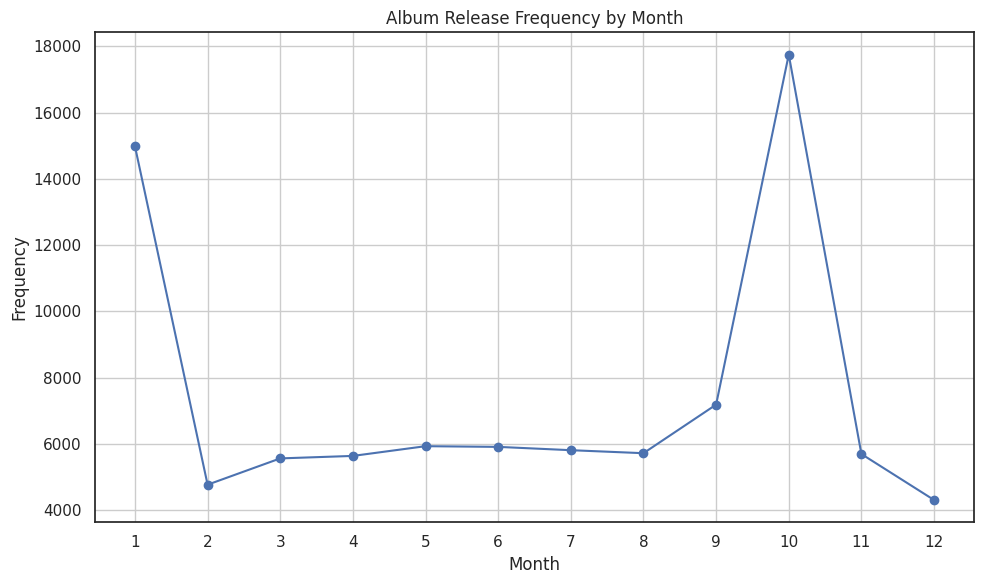

In [49]:
# Get unique values of album_release_month and their frequencies
months = df_tracks['album_release_month'].value_counts().index.sort_values()
frequencies = df_tracks['album_release_month'].value_counts()[months]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(months, frequencies, marker='o', linestyle='-')
plt.title('Album Release Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

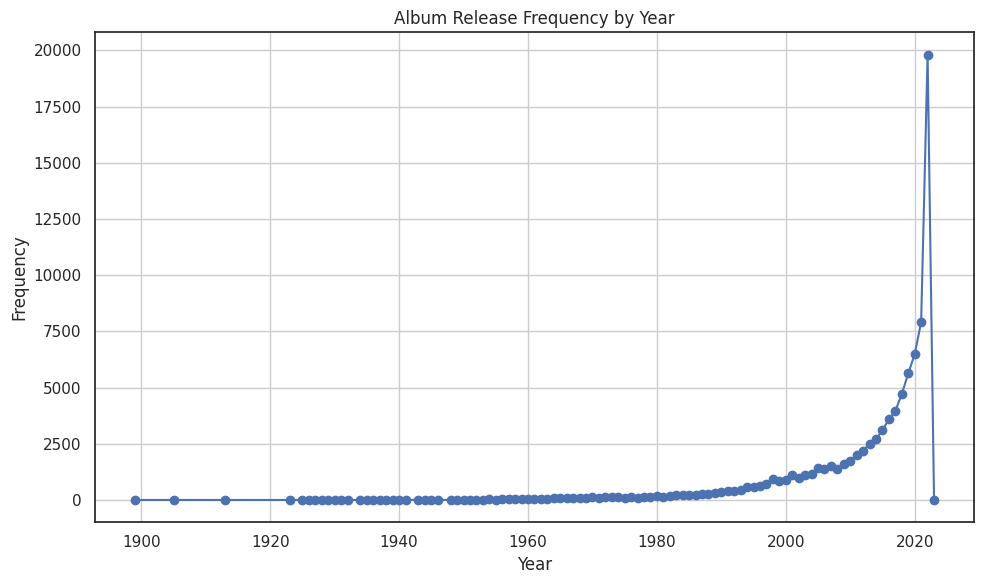

In [50]:
# Get unique values of album_release_year and their frequencies
years = df_tracks['album_release_year'].value_counts().index.sort_values()
frequencies = df_tracks['album_release_year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, frequencies, marker='o', linestyle='-')
plt.title('Album Release Frequency by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


###  Most common artists genres from Top 1000 artist by popularity

In [51]:
top_1000_artists_genre = df_artists.sort_values(by='popularity', ascending=False)[:1000]

In [52]:
top_1000_artists_genre = top_1000_artists_genre['genres']

In [53]:
genres_sorted_by_popularity = {}
for lista in top_1000_artists_genre:
    for element in lista:
        genres_sorted_by_popularity[element] = genres_sorted_by_popularity.get(element, 0) + 1
        
        
for key, frequency in genres_sorted_by_popularity.items():
    if frequency > 30:
        print(f"{key}: {frequency}")

pop: 148
hip hop: 66
pop rap: 58
rap: 96
reggaeton: 60
trap latino: 65
urbano latino: 79
trap: 48
filmi: 59
modern bollywood: 43
dance pop: 63
edm: 35
pop dance: 44
latin pop: 42
modern rock: 35
rock: 100
alternative metal: 31
classic rock: 36


In [54]:
top_genre_artist = {}
top_genre_artist['pop k-pop'] = genres_sorted_by_popularity['pop'] + genres_sorted_by_popularity['k-pop']

top_genre_artist['alternative-rock'] =genres_sorted_by_popularity['rock']
top_genre_artist['hip-hop'] = genres_sorted_by_popularity['hip hop']
top_genre_artist['raggaeton'] = genres_sorted_by_popularity['reggaeton'] # We checkd that in the raggae class the first 50 are raggeaton actually
top_genre_artist['house'] = genres_sorted_by_popularity['house']
top_genre_artist['dance'] = genres_sorted_by_popularity['pop dance'] + genres_sorted_by_popularity['dance pop']
top_genre_artist['indie_indie-pop'] = genres_sorted_by_popularity['pov: indie'] + genres_sorted_by_popularity['indie pop']

In [55]:
top_genre_artist

{'pop k-pop': 166,
 'alternative-rock': 100,
 'hip-hop': 66,
 'raggaeton': 60,
 'house': 8,
 'dance': 107,
 'indie_indie-pop': 34}

In [56]:
for key, value in genres_sorted_by_popularity.items():
    if value > 50:
        print(f"{key}: {value}")

pop: 148
hip hop: 66
pop rap: 58
rap: 96
reggaeton: 60
trap latino: 65
urbano latino: 79
filmi: 59
dance pop: 63
rock: 100


### Most common tracks genres from Top 1000 artist by popularity

In [57]:
top_1000_genre_df = df_tracks.sort_values(by='popularity', ascending=False)[:1000]

In [58]:
top_1000_genre = top_1000_genre_df['genre']

In [59]:
top_1000_genre = top_1000_genre.values

In [60]:
labels, counts = np.unique(top_1000_genre, return_counts=True)

for label, count in zip(labels, counts):
    if count > 25:
        print(f"{label}: {count}")

alternative: 60
dance: 67
electro: 27
hip-hop: 56
house: 74
indie: 26
indie-pop: 59
k-pop: 31
pop: 99
reggae: 51
reggaeton: 27
rock: 50
songwriter: 31
soul: 40


In [61]:
genres_sorted = {}
for element in top_1000_genre:
    genres_sorted[element] = genres_sorted.get(element, 0) + 1

In [62]:
top_genre = {}
top_genre['pop k-pop'] = genres_sorted['pop'] + genres_sorted['k-pop']
top_genre['alternative-rock'] = genres_sorted['alternative'] + genres_sorted['rock']
top_genre['hip-hop'] = genres_sorted['hip-hop']
top_genre['raggaeton'] = genres_sorted['reggaeton'] + genres_sorted['reggae'] # We checkd that in the raggae class the first 50 are raggeaton actually
top_genre['house'] = genres_sorted['house']
top_genre['dance'] = genres_sorted['dance']
top_genre['indie_indie-pop'] = genres_sorted['indie'] + genres_sorted['indie-pop']

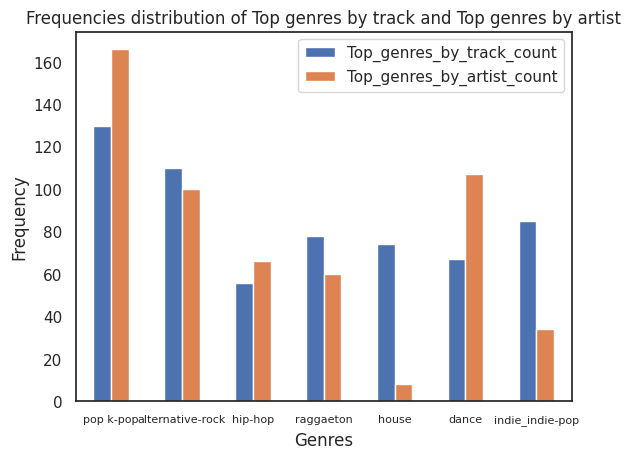

In [63]:
df = pd.DataFrame({'Top_genres_by_track_count': top_genre.values(), 'Top_genres_by_artist_count': top_genre_artist.values()}, index=top_genre.keys())

# Plot the DataFrame
ax = df.plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_xlabel('Genres')
plt.title('Frequencies distribution of Top genres by track and Top genres by artist')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
ax.tick_params(axis='x', labelsize=8)
plt.show()

## Distributions 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

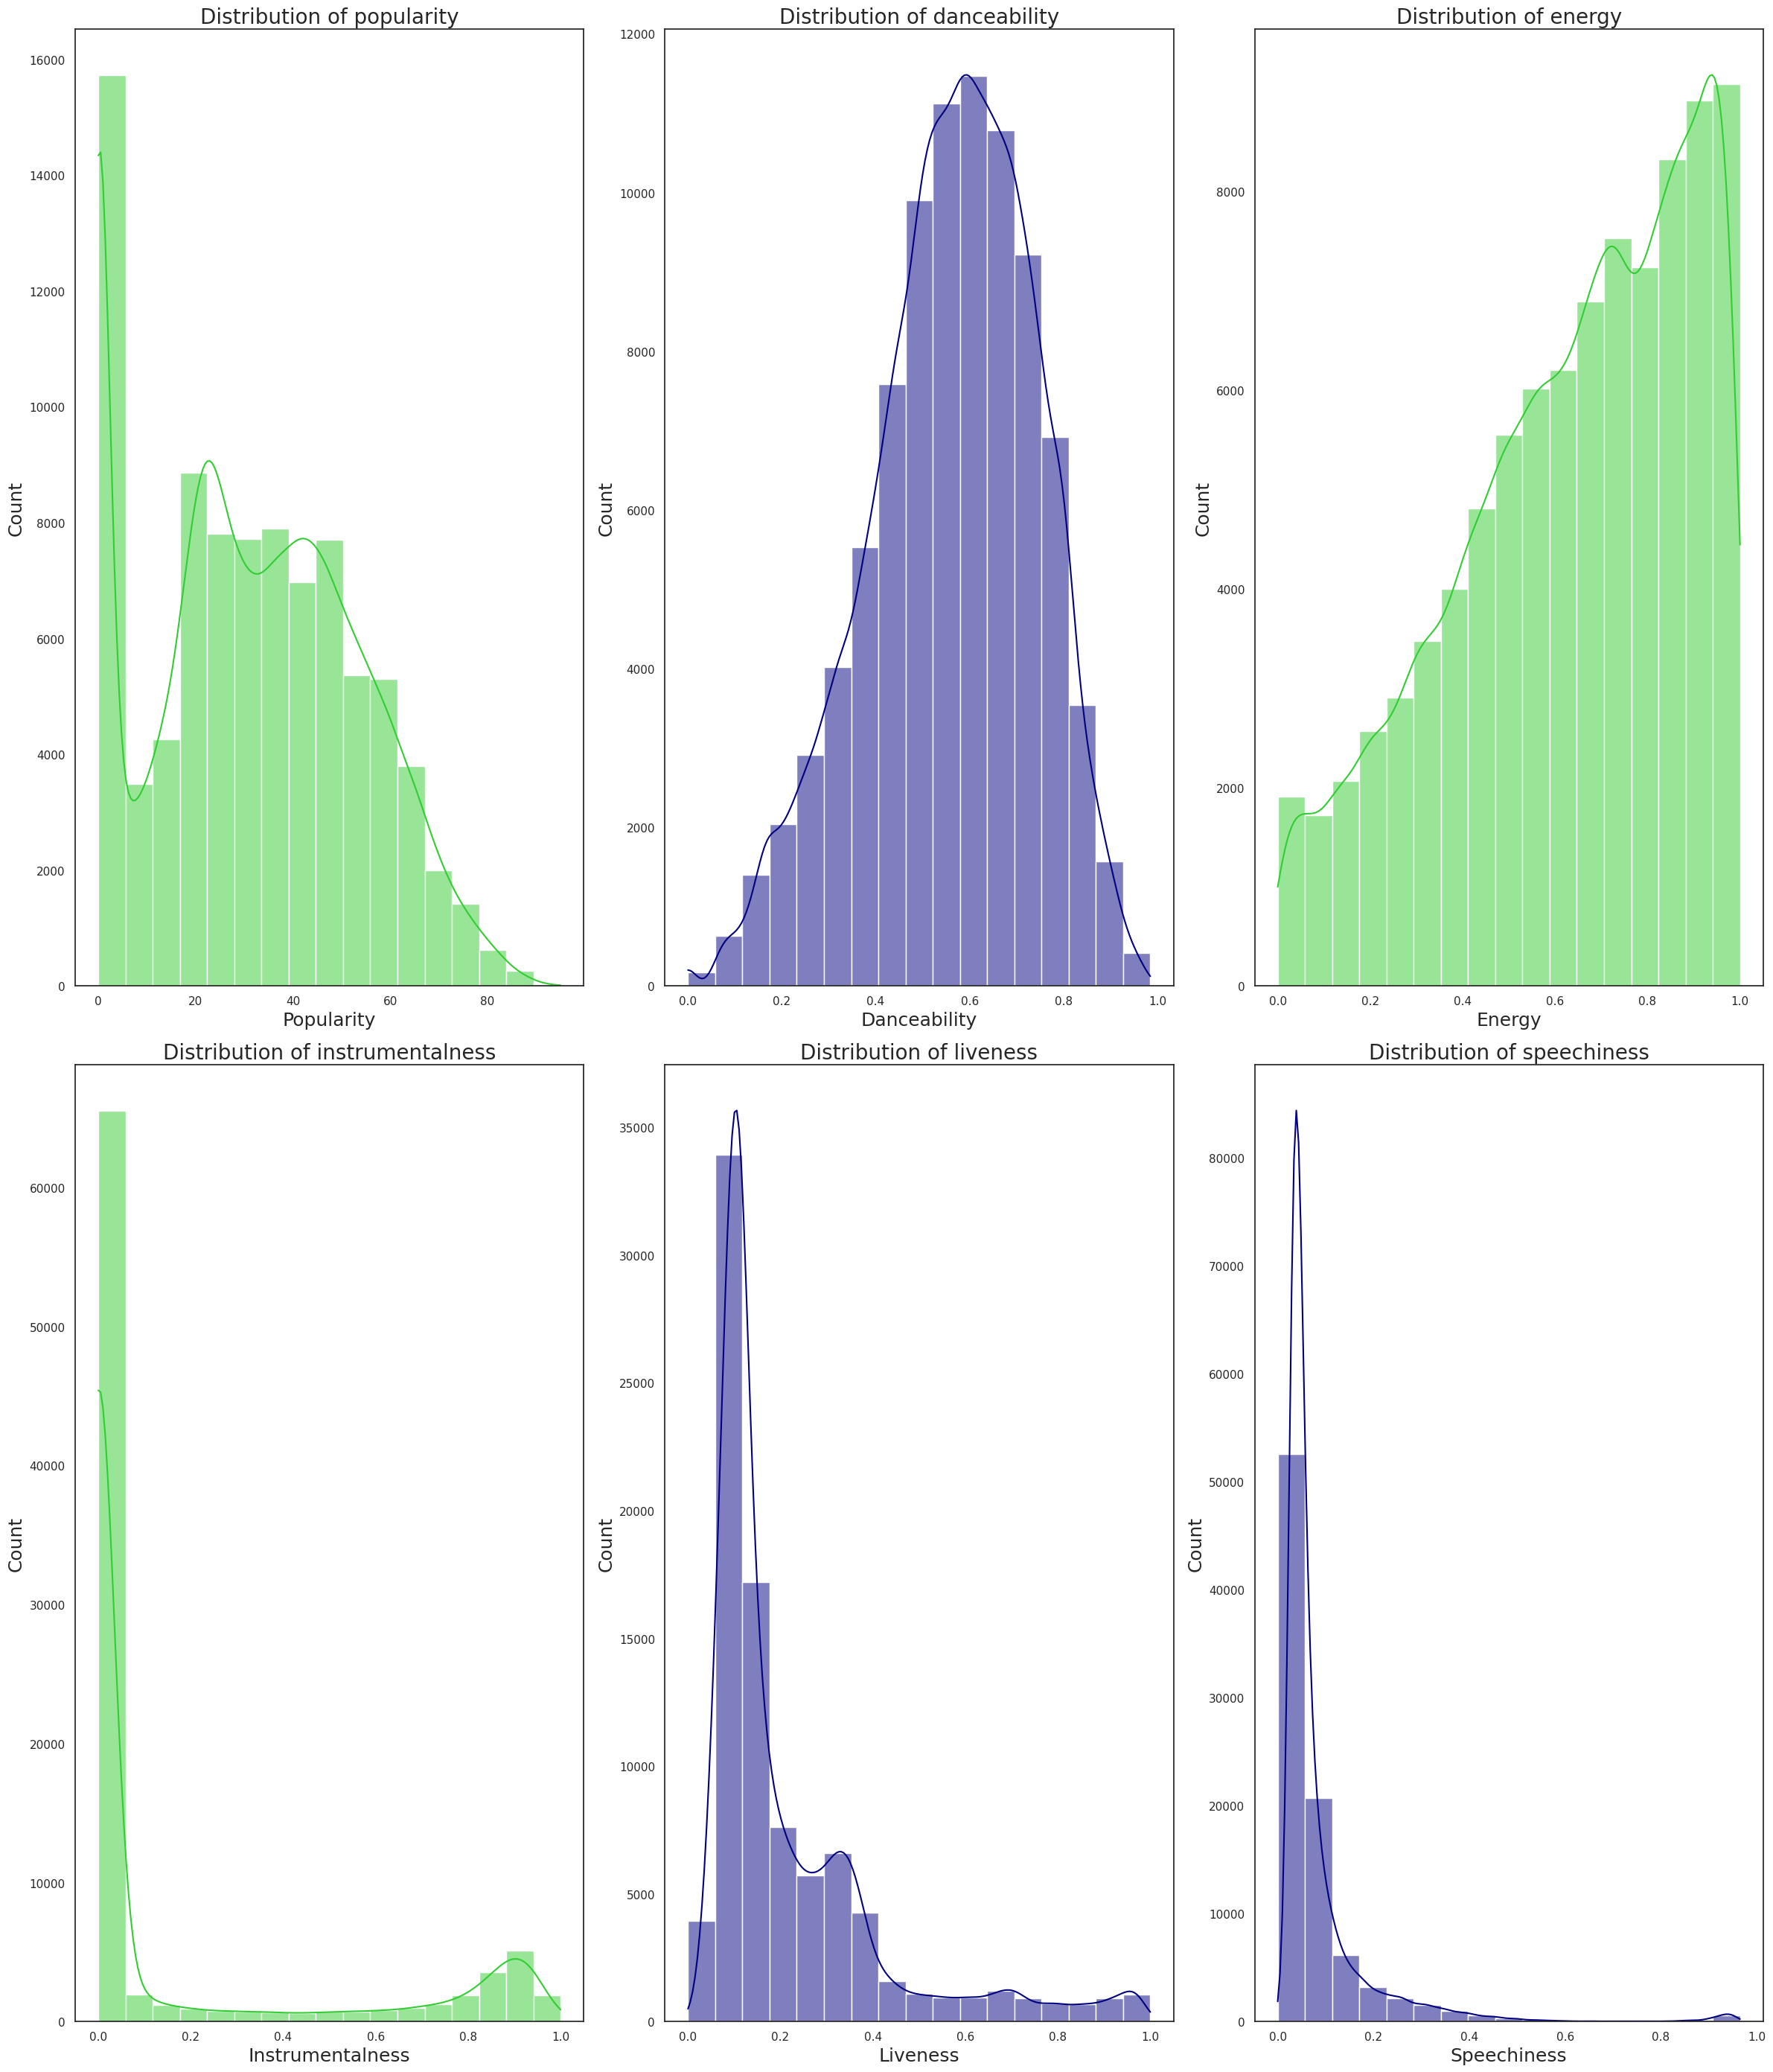

In [64]:
# After some trial-and-error, plotting the most insightful features

# Set up a grid of plots
fig = plt.figure(figsize=(24, 28)) 
fig_dims = (2, 3)

# Plot popularity
plt.subplot2grid(fig_dims, (0, 0))
sns.histplot(df_tracks['popularity'], bins=17, kde=True, color='limegreen')
plt.title('Distribution of popularity', fontsize=20)  # Decrease font size
plt.xlabel('Popularity', fontsize=18)  # Decrease font size
plt.ylabel('Count', fontsize=18)  # Decrease font size

# Plot danceability
plt.subplot2grid(fig_dims, (0, 1))
sns.histplot(df_tracks['danceability'], bins=17, kde=True, color='navy')
plt.title('Distribution of danceability', fontsize=20)  # Decrease font size
plt.xlabel('Danceability', fontsize=18)  # Decrease font size
plt.ylabel('Count', fontsize=18)  # Decrease font size

# Plot energy
plt.subplot2grid(fig_dims, (0, 2))
sns.histplot(df_tracks['energy'], bins=17, kde=True, color='limegreen')
plt.title('Distribution of energy', fontsize=20)  # Decrease font size
plt.xlabel('Energy', fontsize=18)  # Decrease font size
plt.ylabel('Count', fontsize=18)  # Decrease font size

# Plot instrumentalness
plt.subplot2grid(fig_dims, (1, 0))
sns.histplot(df_tracks['instrumentalness'], bins=17, kde=True, color='limegreen')
plt.title('Distribution of instrumentalness', fontsize=20)  # Decrease font size
plt.xlabel('Instrumentalness', fontsize=18)  # Decrease font size
plt.ylabel('Count', fontsize=18)  # Decrease font size

# Plot liveness
plt.subplot2grid(fig_dims, (1, 1))
sns.histplot(df_tracks['liveness'], bins=17, kde=True, color='navy')
plt.title('Distribution of liveness', fontsize=20)  # Decrease font size
plt.xlabel('Liveness', fontsize=18)  # Decrease font size
plt.ylabel('Count', fontsize=18)  # Decrease font size

# Plot speechiness
plt.subplot2grid(fig_dims, (1, 2))
sns.histplot(df_tracks['speechiness'], bins=17, kde=True, color='navy')
plt.title('Distribution of speechiness', fontsize=20)  # Decrease font size
plt.xlabel('Speechiness', fontsize=18)  # Decrease font size
plt.ylabel('Count', fontsize=18)  # Decrease font size

# Adjust space between plots
plt.subplots_adjust(hspace=2)

plt.tight_layout()
plt.show()

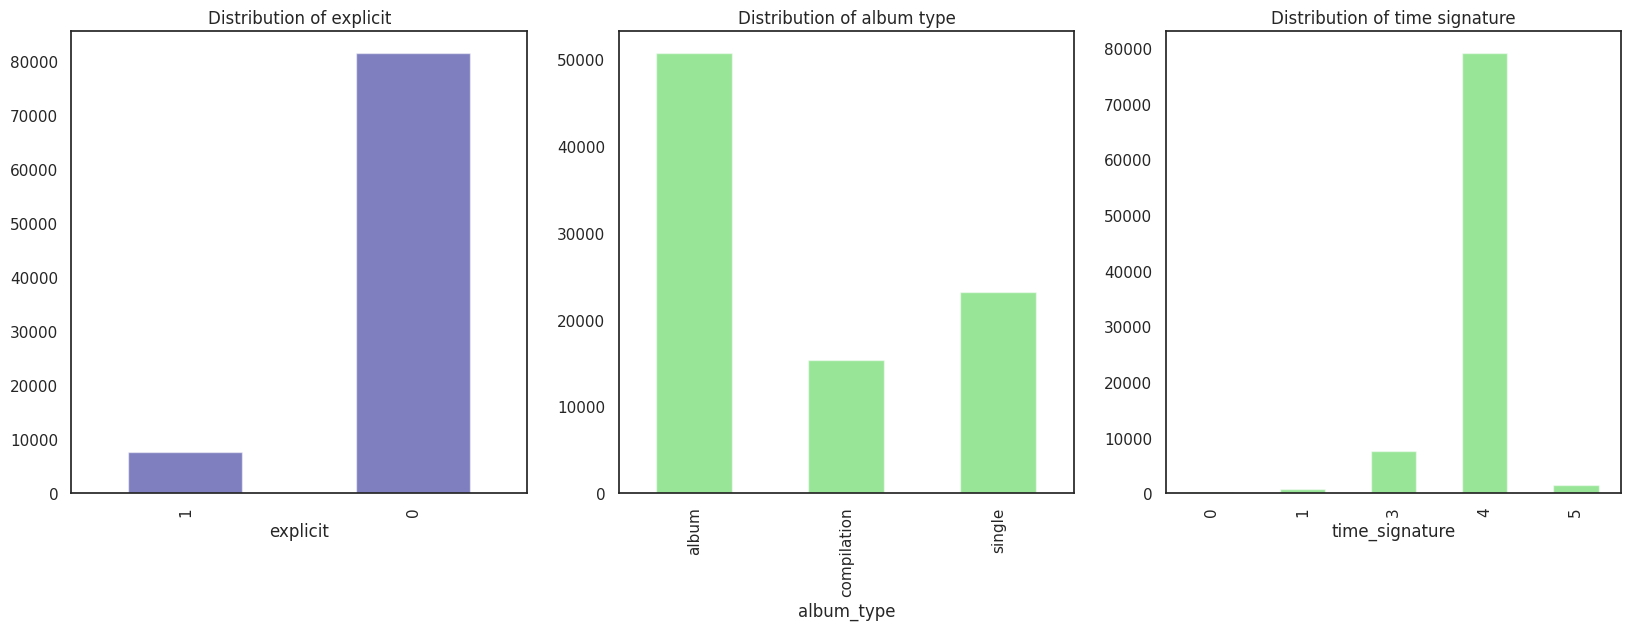

In [65]:
# Categorical feature distributions

# Set up a grid of plots
fig = plt.figure(figsize=(20,6)) 
fig_dims = (1, 3)


# Plot explicit
plt.subplot2grid(fig_dims, (0, 0))
df_tracks['explicit'].value_counts().sort_index(ascending = False).plot(kind='bar',color= 'navy',
                                   title='Distribution of explicit', alpha=.5)


# Plot album_type
plt.subplot2grid(fig_dims, (0, 1))
df_tracks['album_type'].value_counts().sort_index().plot(kind='bar', color= 'limegreen', 
                                   title='Distribution of album type', alpha=.5)

#Plot time_signature
plt.subplot2grid(fig_dims, (0, 2))
df_tracks['time_signature'].value_counts().sort_index().plot(kind='bar', color= 'limegreen',
                                   title='Distribution of time signature', alpha=.5)



plt.show()

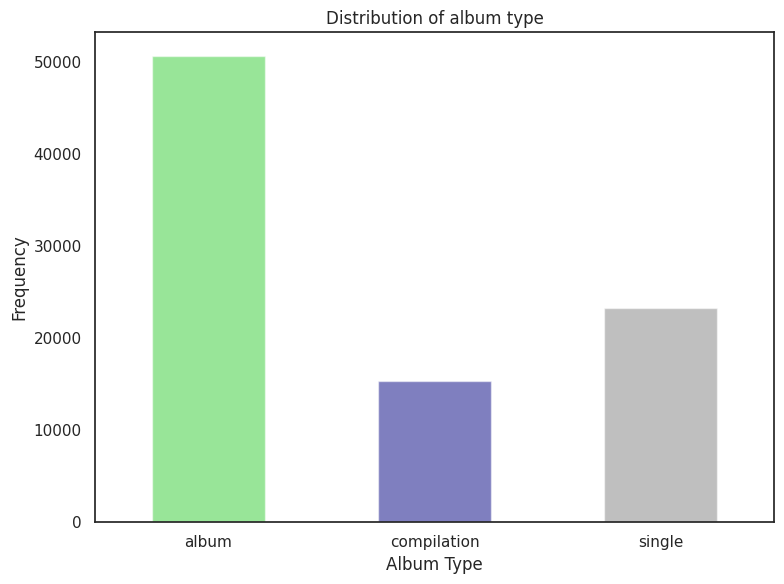

In [66]:
# Distribution of categorical feature "album_type"

# Define colors for bars
colors = ['limegreen', 'navy', (0.5, 0.5, 0.5)]  # The third color is a mix of lime green and navy

# Plot album_type
plt.figure(figsize=(8, 6))  # Set the figure size
df_tracks['album_type'].value_counts().sort_index().plot(kind='bar', color=colors, 
                                                  title='Distribution of album type', alpha=0.5)
plt.xlabel('Album Type')  
plt.ylabel('Frequency')  
plt.xticks(rotation=0)  
plt.grid(False)  
plt.tight_layout()  
plt.show()

## Clustering

In [67]:
#### We want a smaller number of genres to be able to subsequent perform advanced classification 

df_tracks

,id,name,duration_ms,explicit,popularity,artists,album_type,album_name,album_release_date,album_total_tracks,...,genre,album_release_year,album_release_month,fade_out_duration,primary_artist_id,other_artists_id,primary_artist_popularity,other_artists_popularity,average_artists_popularity,sum_of_followers
0,4rjA5kJJWbwU1prXCvg6Fk,Grey,290479,0,52,Kölsch,album,1989,2017-09-22,13,...,minimal-techno,2017,9,14574,2D9Oe8R9UhbMvFAsMJpXj0,[],51,[],51,218818
1,6xzpUzzIquIyUzTLbbgSdI,Thrown,539229,0,45,Kiasmos,album,Kiasmos,2014-10-27,8,...,minimal-techno,2014,10,21947,6X8lhZ7YaRUBlOsOYimlyD,[],47,[],47,231613
2,56tXgHlSHCfgmGhwVXNizc,Routine,264200,0,39,Joris Delacroix,album,Night Visions,2018-06-22,10,...,minimal-techno,2018,6,5159,3HRRzIZNQFus3xlUx2xKy1,[],44,[],44,100828
3,0s3wIBczp6TdSJ2y8cveJl,Confronted - Anfisa Letyago Stranger Remix,387413,0,0,Pan-Pot;Anfisa Letyago,single,Confronted Remixes,2019-12-06,7,...,minimal-techno,2019,12,0,6OQOvP7RAdmAKVXXQqD0Se,[7icoOm5fKKPo49jVxoj1Cq],36,[40],38,296613
4,4PSbDDd1LRYMhqPXvza6I2,Jupiter Sunrise,248956,0,0,Kollektiv Turmstrasse,compilation,10 Years Diynamic,2016-09-16,13,...,minimal-techno,2016,9,9321,1oXiuCd5F0DcnmXH5KaM6N,[],45,[],45,245839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109542,0wiDjWz3U1WfwXSrWHXe2b,I'm Good (Blue) - REAPER Extended Remix,209655,1,23,David Guetta;Bebe Rexha;REAPER,single,I'm Good (Blue) [REAPER Remix],2022-10-21,2,...,edm,2022,10,9552,1Cs0zKBU1kc0i8ypK3B9ai,"[64M6ah0SkkRsnPGtGiRAbb, 24kY0bUku58QhWv5WFFXaf]",86,"[79, 50]",72,34880257
109543,46n9OJc7LOIVdj8t2l5WA5,End Of The Night,205724,1,56,Danny Avila,single,End Of The Night,2018-11-16,1,...,edm,2018,11,4738,5y3G1B8cpCTaoq0uDgjwzH,[],47,[],47,46184
109544,127uq83uGFapbddqiMUKky,Sexy Bitch (feat. Akon),195853,1,80,David Guetta;Akon,album,One More Love,2010-11-22,28,...,edm,2010,11,6367,1Cs0zKBU1kc0i8ypK3B9ai,[0z4gvV4rjIZ9wHck67ucSV],86,[79],82,30348451
109545,0ZdUHFxifUJNqo7G4aJzoF,Savannah,208698,0,60,Diviners;Philly K.,single,Savannah,2015-11-25,1,...,edm,2015,11,11282,22lnnGKlaDxk8sfzCNRJuA,[1v8lhkt5jZgHT8xi1wYNUS],47,[38],42,77107


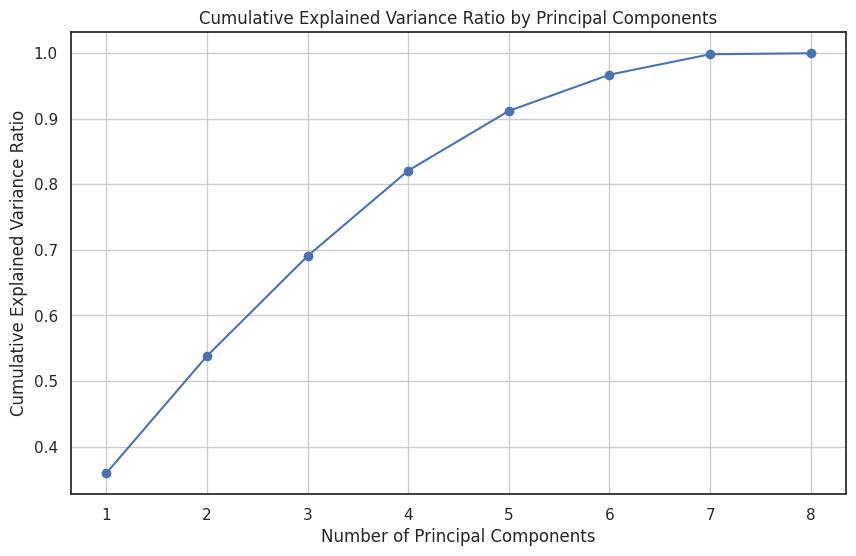

In [68]:
#### Let's try first by performing a PCA to reduce the dimensionality

# Selecting the continuous attributes for PCA
selected_attributes = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 
                         'valence', 'popularity', 'duration_ms']

# Creating a DataFrame with only the selected continuous attributes
df_sel = df_tracks[selected_attributes]

# Standardizing the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_sel_minmax = scaler.fit_transform(df_sel)

# Performing PCA
pca = PCA()
pca.fit(df_sel_minmax)

# Plotting the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [69]:
# Retaining the first five principal components
pca = PCA(n_components=5)
principal_components = pca.fit_transform(df_sel_minmax)

# Creating a DataFrame for the principal components
df_principal_components = pd.DataFrame(data=principal_components, 
                                       columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])


In [70]:
# Concatenating 'genre' and 'id' columns from df_tracks to df_principal_components
df_principal_components['genre'] = df_tracks['genre']
df_principal_components['id'] = df_tracks['id']



In [71]:
df_principal_components

,PC1,PC2,PC3,PC4,PC5,genre,id
0,0.402217,-0.027365,0.027303,0.248860,-0.014112,minimal-techno,4rjA5kJJWbwU1prXCvg6Fk
1,0.573464,-0.063913,-0.160643,0.240287,-0.024521,minimal-techno,6xzpUzzIquIyUzTLbbgSdI
2,0.244329,0.117388,-0.084236,0.191501,-0.139380,minimal-techno,56tXgHlSHCfgmGhwVXNizc
3,0.681064,0.170906,-0.015917,-0.181590,-0.176830,minimal-techno,0s3wIBczp6TdSJ2y8cveJl
4,0.731295,0.412321,-0.035412,-0.096535,-0.179556,minimal-techno,4PSbDDd1LRYMhqPXvza6I2
...,...,...,...,...,...,...,...
89220,0.071854,0.265670,0.330142,-0.046951,-0.027644,malay,2t15oG64hBmlx9Y87x2Jg0
89221,-0.120482,-0.181634,0.093081,0.232817,-0.195407,malay,0fD1fq7QV8CyDweIx0D8qF
89222,-0.398128,-0.058447,-0.223056,0.508438,0.060646,malay,6o8TVsJ32zgciInnkbWPvk
89223,-0.176566,-0.130206,0.083250,0.288607,-0.219925,malay,62YZgmkxQ64x3ZApd6oV7j


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

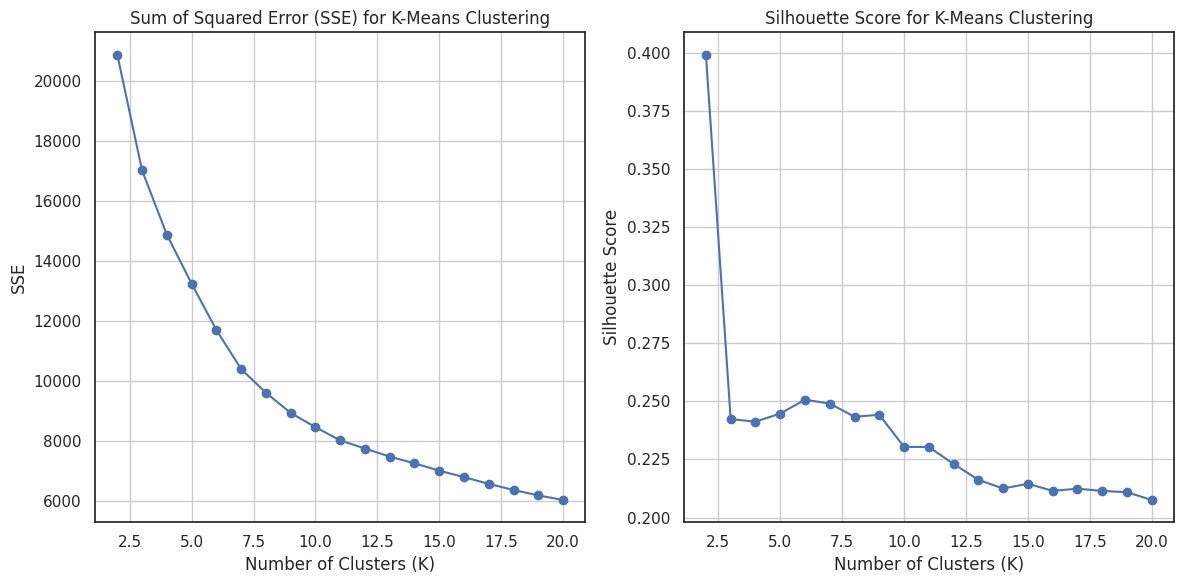

In [72]:
# Selecting the principal components for clustering (assuming PC=5)
X = df_principal_components[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

# Iterating over different values of K and calculating SSE and Silhouette Score
sse = []
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    # SSE
    sse.append(kmeans.inertia_)
    
    # Silhouette Score
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting SSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 21), sse, marker='o', linestyle='-')
plt.title('Sum of Squared Error (SSE) for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.grid(True)

# Plotting Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


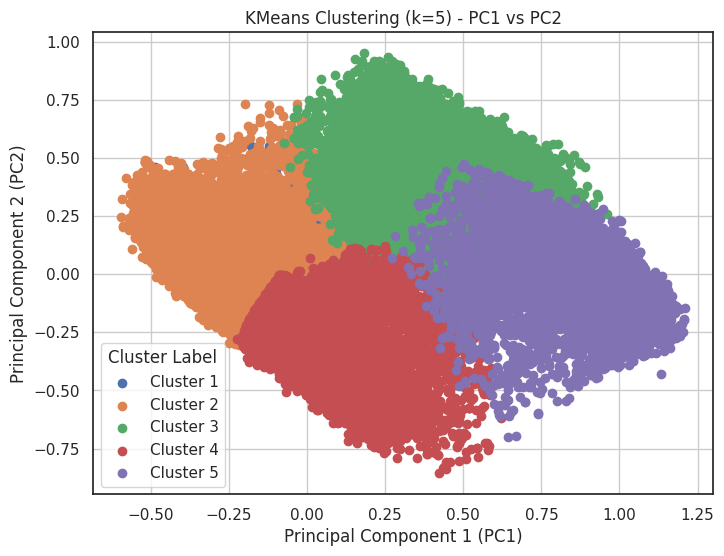

In [73]:
# Perform KMeans clustering with k=5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Add cluster labels to the DataFrame
df_principal_components['Cluster_Labels'] = kmeans.labels_

# Define custom cluster labels
cluster_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

# Visualize the clusters in 2D using PC1 and PC2
plt.figure(figsize=(8, 6))
# Scatter plot with custom cluster labels
for cluster_label in range(5):
    plt.scatter(df_principal_components.loc[df_principal_components['Cluster_Labels'] == cluster_label, 'PC1'],
                df_principal_components.loc[df_principal_components['Cluster_Labels'] == cluster_label, 'PC2'],
                label=cluster_labels[cluster_label])

plt.title('KMeans Clustering (k=5) - PC1 vs PC2')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
# Add custom cluster labels to legend
plt.legend(title='Cluster Label')
plt.grid(True)
plt.show()


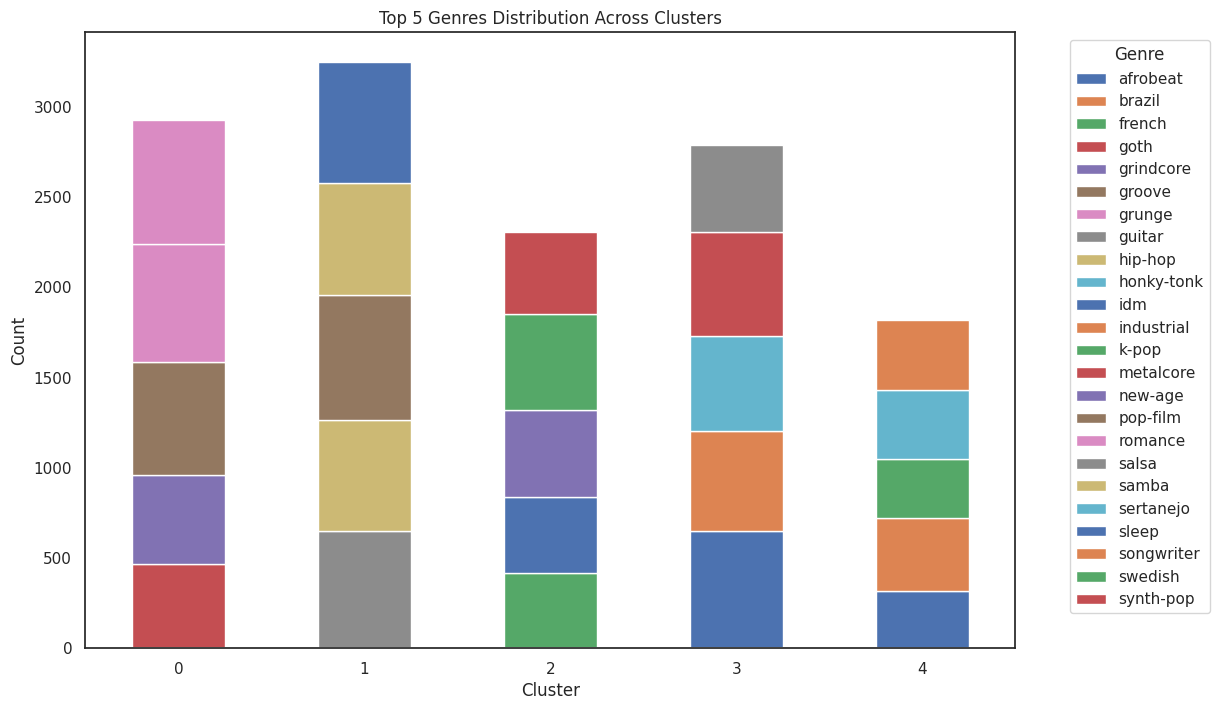

In [74]:
### Checking genre distribution

# Define the number of top genres to ease visualization
top_n_genres = 5

# Group by cluster_labels and genre, count occurrences, and unstack to get genre counts for each cluster
genre_counts = df_principal_components.groupby(['Cluster_Labels', 'genre']).size().unstack(fill_value=0)

# Get the top N genres for each cluster
top_genres_per_cluster = genre_counts.apply(lambda x: x.sort_values(ascending=False).head(top_n_genres), axis=1)

# Plot stacked bar chart
top_genres_per_cluster.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title(f'Top {top_n_genres} Genres Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Cluster 1: {romance, grunge, groove, grindcore, goth}
Cluster 2: {pop-film, sleep, guitar, samba, hip-hop}
Cluster 3: {swedish, new-age, synth-pop, idm, french}
Cluster 4: {afrobeat, metalcore, brazil, honky-tonk, salsa}
Cluster 5: {industrial, sertanejo, songwriter, k-pop, idm}


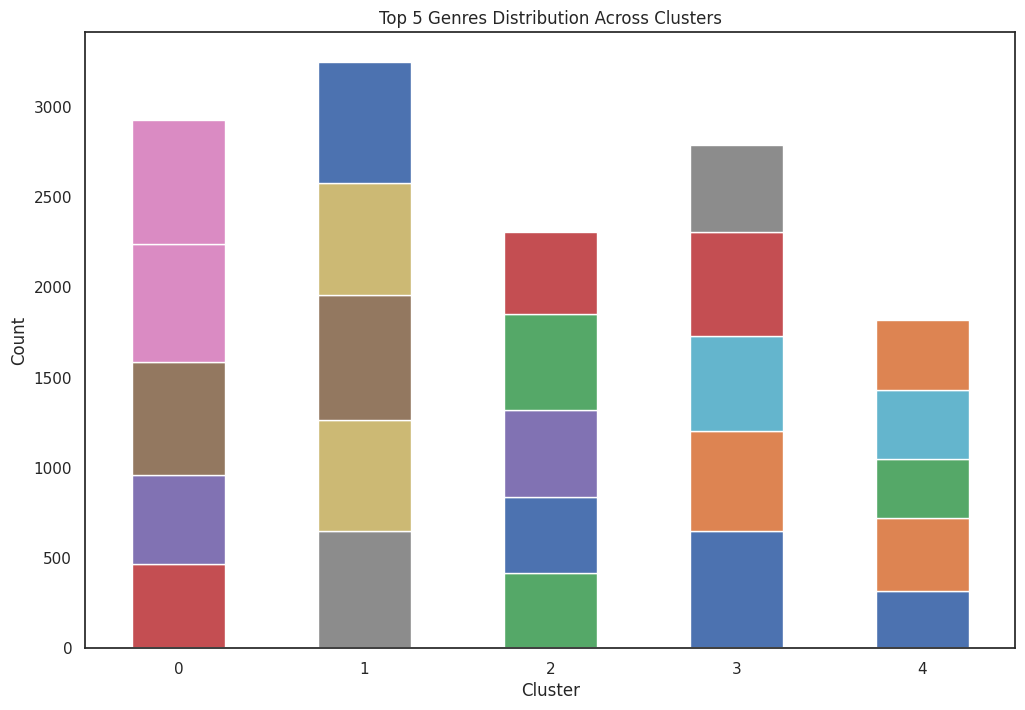

In [75]:
## Improve visualization clarity and printing genres

# Plot stacked bar chart
ax = top_genres_per_cluster.plot(kind='bar', stacked=True, figsize=(12, 8), legend=False)

# Get the top N genres for each cluster
top_genres_per_cluster = genre_counts.apply(lambda x: x.sort_values(ascending=False).index[:top_n_genres], axis=1)

# Print top genres for each cluster
for i, top_genres in enumerate(top_genres_per_cluster, start=1):
    print(f'Cluster {i}: {{{", ".join(top_genres)}}}')

plt.title(f'Top {top_n_genres} Genres Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [76]:
# Assign Cluster labels from df_principal_components to df_tracks
df_tracks['cluster_label'] = df_principal_components['Cluster_Labels'].iloc[:]


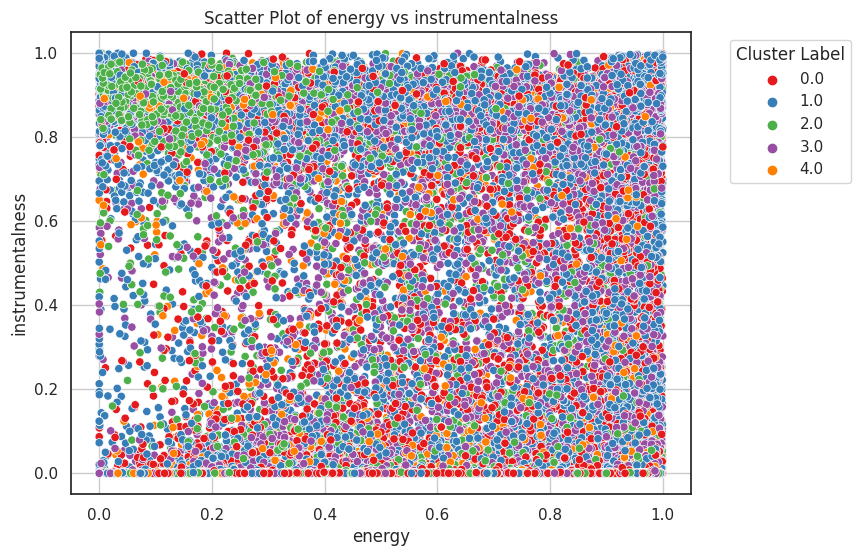

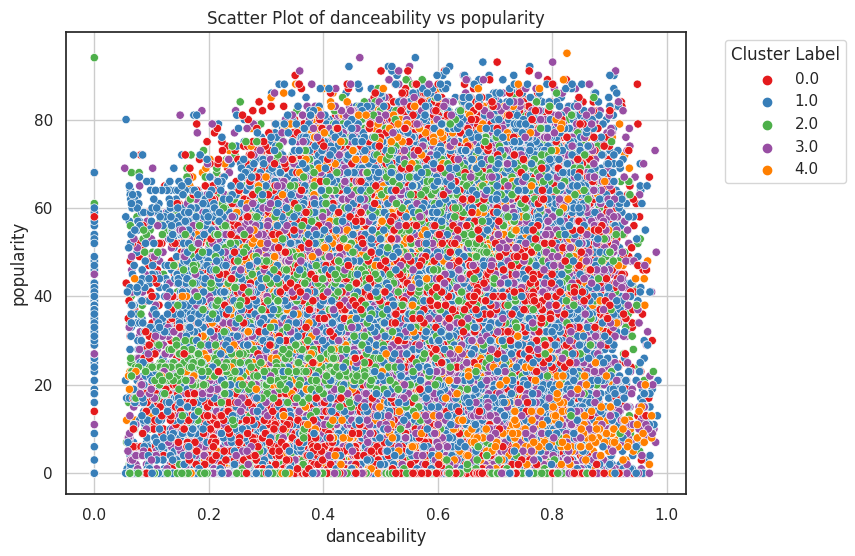

In [77]:
# Define the pairs of features to visualize (they were the most informative after some trial and error)
feature_pairs = [("energy", "instrumentalness"), ("danceability", "popularity")]

# Loop over each pair of features
for pair in feature_pairs:
    # Create a scatter plot for the current pair of features
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pair[0], y=pair[1], hue='cluster_label', data=df_tracks, palette='Set1', legend='full')
    plt.title(f'Scatter Plot of {pair[0]} vs {pair[1]}')
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


In [78]:
# Define a dictionary to map original cluster labels to desired names
cluster_label_mapping = {
    0: "Low_insMid_en",
    1: "Low_insLow_en",
    2: "Low_insHigh_en",
    3: "High_insLow_en",
    4: "High_insHigh_en"
}

# Get unique cluster labels
cluster_labels = df_tracks['cluster_label'].unique()

# Loop over each cluster label
for label in cluster_labels:
    # Map the original cluster label to the desired name
    cluster_name = cluster_label_mapping.get(label, f"Cluster {label}")
    # Filter df_tracks for the current cluster label
    cluster_df = df_tracks[df_tracks['cluster_label'] == label]
    # Calculate value counts of genres within the filtered subset
    genre_counts = cluster_df['genre'].value_counts()
    # Print the value counts for the current cluster with the renamed cluster name
    print(f'{cluster_name}:')
    print(genre_counts)
    print()  # Add a blank line for clarity


Low_insHigh_en:
genre
swedish              534
new-age              484
synth-pop            451
idm                  419
french               417
                    ... 
reggae                 3
happy                  3
pop                    2
edm                    2
progressive-house      1
Name: count, Length: 88, dtype: int64

High_insHigh_en:
genre
industrial    402
sertanejo     387
songwriter    386
k-pop         325
idm           319
             ... 
grindcore       1
bluegrass       1
afrobeat        1
latino          1
pop             1
Name: count, Length: 79, dtype: int64

High_insLow_en:
genre
afrobeat      649
metalcore     579
brazil        556
honky-tonk    523
salsa         480
             ... 
samba          20
groove         17
indie          17
alt-rock       15
latin          14
Name: count, Length: 90, dtype: int64

Low_insLow_en:
genre
pop-film      693
sleep         672
guitar        651
samba         619
hip-hop       616
             ... 
latino         4